PERFILAMIENTO DE DATOS

In [1]:
seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, minmax_scale

#Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

#DBScan
from sklearn.cluster import DBSCAN

In [2]:
# Se cargan los datos. 
df_original = pd.read_csv('202120_Laboratorio_2_datos_BancAlpes_credit_card_data.csv', sep=';', encoding = 'utf-8', index_col = 0, na_values=['-','ABC','nan','?'])
df_customers = df_original.copy()
df_customers.head(5)

,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Id,,,,,,,,,,
1,87073.0,20000.0,Female,2.0,Married,24.0,2.0,1.0,1.0,0.0
2,38414.0,120000.0,Female,2.0,Single,26.0,3.0,0.0,10.0,9.0
3,17341.0,90000.0,Female,2.0,Single,34.0,7.0,1.0,3.0,4.0
4,40496.0,50000.0,Female,2.0,Married,37.0,5.0,1.0,1.0,NaN
5,47437.0,50000.0,Male,2.0,Married,57.0,6.0,0.0,12.0,3.0


In [3]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer             658 non-null    float64
 1   Limit_bal            659 non-null    float64
 2   Sex                  659 non-null    object 
 3   Education            658 non-null    float64
 4   Marriage             657 non-null    object 
 5   Age                  659 non-null    float64
 6   Total_Credit_Cards   658 non-null    float64
 7   Total_visits_bank    656 non-null    float64
 8   Total_visits_online  659 non-null    float64
 9   Total_calls_made     658 non-null    float64
dtypes: float64(8), object(2)
memory usage: 56.7+ KB


In [4]:
#Se dividen las columnas entre numéricas y no numéricas
df_num = df_customers.select_dtypes(include = ['int','float']).copy()
df_no_num = df_customers.select_dtypes(include = ['object']).copy()

In [5]:
df_num.describe()

,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,658.000000,659.000000,658.000000,659.000000,6.580000e+02,656.00000,659.000000,658.000000
mean,55180.056231,170000.000000,1.781155,95.218513,1.876290e+05,2.41311,2.602428,3.579027
std,25651.348197,129739.041329,0.778797,1432.660847,4.812847e+06,1.63130,2.936469,2.868076
min,11265.000000,10000.000000,1.000000,21.000000,1.000000e+00,0.00000,0.000000,0.000000
25%,33875.500000,50000.000000,1.000000,28.000000,3.000000e+00,1.00000,1.000000,1.000000
50%,53907.000000,140000.000000,2.000000,33.000000,5.000000e+00,2.00000,2.000000,3.000000
75%,77321.500000,240000.000000,2.000000,41.000000,6.000000e+00,4.00000,4.000000,5.000000
max,99843.000000,630000.000000,6.000000,36745.000000,1.234568e+08,5.00000,15.000000,10.000000


In [6]:
#Tiene sentido pasar ambos datos a numéricos porque es información que puede ayudar a la orientación del Marketing del banco
df_no_num.describe()

,Sex,Marriage
count,659,657
unique,9,6
top,Female,Single
freq,372,379


In [7]:
df_no_num['Sex'].value_counts()

Female    372
Male      273
M           3
F           3
Mael        3
f           2
Fmale       1
Femael      1
9           1
Name: Sex, dtype: int64

In [8]:
#Se debe agrupar todos los datos mal digitados (f, Femael, Mael, etc.) con los que están bien. Además, 
#eliminar el registro que tiene "9" como género. Sólo es un registro y no es útil clasificarlo como un grupo aparte.
df_no_num= df_no_num.drop(df_no_num[df_no_num['Sex'] == '9'].index)
df_no_num['Sex'].replace(to_replace = ['M','Mael','Male'], value = 'Males', inplace = True)
df_no_num['Sex'].replace(to_replace = ['Female','F','f','Fmale','Femael'], value = 'Females', inplace = True)

In [9]:
df_no_num['Sex'].value_counts()

Females    379
Males      276
M            3
Name: Sex, dtype: int64

In [10]:
df_no_num['Marriage'].value_counts()

Single     378
Married    260
Others       9
1            5
2            3
0            1
Name: Marriage, dtype: int64

In [11]:
df_no_num['Marriage'].replace(to_replace = ['1','2','0','Others'], value = 'O', inplace = True)

In [12]:
#Se convierten en variables numéricos
df_marriage = df_no_num[['Marriage']].copy()
encoder = OneHotEncoder().fit(df_marriage)
print(encoder.categories_)

[array(['Married', 'O', 'Single', nan], dtype=object)]


In [13]:
df_marriage = pd.DataFrame(encoder.transform(df_marriage).toarray(), 
                       columns = np.concatenate(encoder.categories_)) 

In [14]:
df_marriage.head(-10)

,Married,O,Single,NaN
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
644,0.0,0.0,1.0,0.0
645,1.0,0.0,0.0,0.0
646,0.0,0.0,1.0,0.0
647,1.0,0.0,0.0,0.0


In [15]:
#Para simplicidad, se escogerán solamente las columnas Married y Single que son las que más datos poseen y se pueden
#generalizar mejor para el marketing.
df_marriage= df_marriage[['Married','Single']].copy()
df_marriage.head(5)

,Married,Single
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0


In [16]:
df_sex = df_no_num[['Sex']].copy()
encoder = OneHotEncoder().fit(df_sex)
print(encoder.categories_)

[array(['Females', 'M ', 'Males', nan], dtype=object)]


In [17]:
df_sex = pd.DataFrame(encoder.transform(df_sex).toarray(), 
                       columns = np.concatenate(encoder.categories_)) 

In [18]:
df_sex.head(-10)

,Females,M,Males,NaN
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
644,0.0,0.0,1.0,0.0
645,0.0,0.0,1.0,0.0
646,1.0,0.0,0.0,0.0
647,1.0,0.0,0.0,0.0


In [19]:
#Para simplicidad, se escogerán solamente las columnas Females y Males que son las que más datos poseen y se pueden
#generalizar mejor para el marketing.
df_sex= df_sex[['Females','Males']].copy()
df_sex.head(5)

,Females,Males
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [20]:
#Ahora, los datos transformados se unen a los numéricos
df = pd.concat((df_sex, df_marriage, df_num), axis=1)
df

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,1.0,87073.0,20000.0,2.0,24.0,2.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,38414.0,120000.0,2.0,26.0,3.0,0.0,10.0,9.0
3,1.0,0.0,1.0,0.0,17341.0,90000.0,2.0,34.0,7.0,1.0,3.0,4.0
4,0.0,1.0,1.0,0.0,40496.0,50000.0,2.0,37.0,5.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
656,1.0,0.0,0.0,1.0,51108.0,280000.0,2.0,39.0,10.0,1.0,10.0,0.0
657,1.0,0.0,0.0,1.0,60732.0,290000.0,3.0,27.0,10.0,1.0,13.0,2.0
658,1.0,0.0,0.0,1.0,53834.0,190000.0,1.0,28.0,8.0,1.0,9.0,1.0
659,NaN,NaN,NaN,NaN,80655.0,80000.0,1.0,23.0,10.0,1.0,15.0,0.0


In [21]:
df.describe()

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,659.000000,659.000000,659.000000,659.000000,658.000000,659.000000,658.000000,659.000000,6.580000e+02,656.00000,659.000000,658.000000
mean,0.575114,0.418816,0.394537,0.573596,55180.056231,170000.000000,1.781155,95.218513,1.876290e+05,2.41311,2.602428,3.579027
std,0.494701,0.493740,0.489122,0.494930,25651.348197,129739.041329,0.778797,1432.660847,4.812847e+06,1.63130,2.936469,2.868076
min,0.000000,0.000000,0.000000,0.000000,11265.000000,10000.000000,1.000000,21.000000,1.000000e+00,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,33875.500000,50000.000000,1.000000,28.000000,3.000000e+00,1.00000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.000000,53907.000000,140000.000000,2.000000,33.000000,5.000000e+00,2.00000,2.000000,3.000000
75%,1.000000,1.000000,1.000000,1.000000,77321.500000,240000.000000,2.000000,41.000000,6.000000e+00,4.00000,4.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,99843.000000,630000.000000,6.000000,36745.000000,1.234568e+08,5.00000,15.000000,10.000000


In [22]:
#El máximo de Age y Total_Credit_Cards no tiene sentido. No pueden haber personas con 36745 años. Esto puede dañar el DataFrame
agenosense = df[df['Age']>50]
agenosense

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
5,0.0,1.0,0.0,1.0,47437.0,50000.0,2.0,57.0,6.0,0.0,12.0,3.0
12,1.0,0.0,0.0,1.0,NaN,260000.0,1.0,51.0,3.0,NaN,2.0,7.0
34,0.0,1.0,0.0,0.0,61517.0,500000.0,2.0,54.0,1.0,0.0,5.0,6.0
35,0.0,1.0,0.0,1.0,28254.0,500000.0,1.0,58.0,4.0,1.0,3.0,10.0
43,1.0,0.0,1.0,0.0,52363.0,10000.0,2.0,2202.0,4.0,2.0,3.0,4.0
47,1.0,0.0,0.0,0.0,83326.0,20000.0,1.0,36745.0,1.0,2.0,2.0,5.0
51,1.0,0.0,0.0,0.0,51182.0,70000.0,3.0,789.0,1.0,0.0,5.0,9.0
65,0.0,1.0,1.0,0.0,61355.0,130000.0,2.0,51.0,1.0,0.0,5.0,9.0
66,0.0,1.0,1.0,0.0,60403.0,200000.0,1.0,57.0,1.0,1.0,4.0,4.0
67,1.0,0.0,0.0,1.0,85868.0,10000.0,2.0,56.0,2.0,0.0,3.0,6.0


In [23]:
cardsnosense = df[df['Total_Credit_Cards']>10]
cardsnosense

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
75,0.0,1.0,0.0,1.0,33187.0,340000.0,1.0,32.0,123456789.0,0.0,5.0,8.0


In [24]:
#Se ve que hay edades de 2202, 36745 y 789 que deberían ser eliminadas. Asimismo, se puede ver que el máximo valor coherente de Age es 75.
#De igual manera, debe ser borrado el registro de 123456789 tarjetas de crédito. 
#Se borrarán las edades mayores a 75.
df.drop(df.loc[df['Age']>75].index, inplace=True)
#Registro de tarjetas de crédito sin sentido
df.drop(df.loc[df['Total_Credit_Cards']==123456789].index, inplace=True)

In [25]:
#Mediana de cada columna
df.median().to_dict()

{'Females': 1.0,
 'Males': 0.0,
 'Married': 0.0,
 'Single': 1.0,
 'Customer': 53924.0,
 'Limit_bal': 140000.0,
 'Education': 2.0,
 'Age': 33.0,
 'Total_Credit_Cards': 5.0,
 'Total_visits_bank': 2.0,
 'Total_visits_online': 2.0,
 'Total_calls_made': 3.0}

In [26]:
#Para tratar los nulos, se reemplazarán por la mediana (promedio no para evitar análisis con los outliers). Esto se 
#hará debido a que, como se puede apreciar, no hay una columna en específico que tenga la mayor parte de sus datos en 
#nulos. Por tanto, no podemos borrar ninguna columna como estrategia para tratar los nulos.
df.fillna(df.median().to_dict(), inplace = True)
df.isna().sum()

Females                0
Males                  0
Married                0
Single                 0
Customer               0
Limit_bal              0
Education              0
Age                    0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [27]:
#Reescalar los datos. Hay algunos datos incoherentes, como en Age que el máximo es 36745 y en el total de tarjetas de crédito
#que el máximo es 1.234568e+08; ninguno de estos datos tienen sentido.
trans = MinMaxScaler()
trans.fit(df)

df = pd.DataFrame(trans.transform(df), columns = df.columns)
df.describe()

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,0.575342,0.418569,0.394216,0.576865,0.495725,0.258506,0.156469,0.260725,0.414510,0.483714,0.172907,0.355860
std,0.494668,0.493700,0.489054,0.494433,0.289377,0.208767,0.155366,0.173306,0.239634,0.324967,0.195867,0.285685
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.256565,0.080645,0.000000,0.129630,0.222222,0.200000,0.066667,0.100000
50%,1.000000,0.000000,0.000000,1.000000,0.481598,0.209677,0.200000,0.222222,0.444444,0.400000,0.133333,0.300000
75%,1.000000,1.000000,1.000000,1.000000,0.743729,0.370968,0.200000,0.370370,0.555556,0.800000,0.266667,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


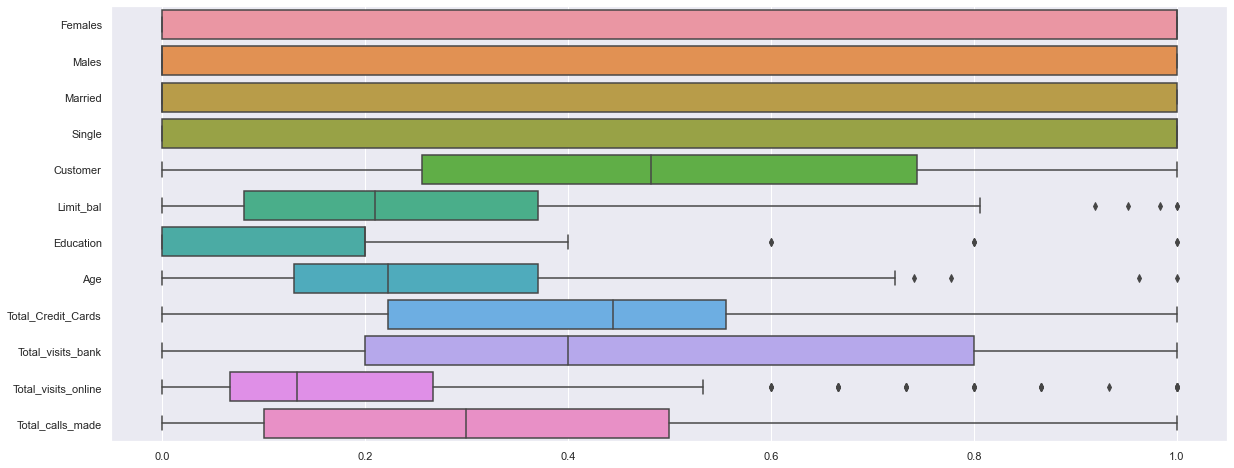

In [28]:
#Columnas con más outliers. Aunque sea Total_visits_online junto a Age, estos outliers no representan un peligro para los datos. Esto debido a que 
#si se pueden dar casos de clientes los cuales visiten constantemente el portal web del banco por diferentes situaciones (revisión de transacciones,
#cambios de contraseña, etc.) o, para Age, el caso en que un cliente sea longevo. No sería buena práctica quitarlos. Sí sería buena práctica quitar 
#outliers de Limit_bal, puesto que estos datos atípicos sí pueden estar dañando el análisis de datos porque es extraño que a una persona se le permita
#obtener más dinero de las tarjetas de crédito. En caso de que así sea, se evaluarían esos clientes en un clúster aparte. Por tanto, es mejor quitarlos
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df, orient="h")

In [29]:
#Uso de desviación estándar para identificar outliers de Limit_bal 
per = 95
limit = (df['Limit_bal'] > np.percentile(df['Limit_bal'].dropna() , per))
df_out = df[limit ]
df_out

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
7,1.0,0.0,0.0,1.0,0.418896,0.790323,0.0,0.148148,0.444444,0.0,0.733333,0.2
13,0.0,1.0,0.0,1.0,0.917135,1.000000,0.2,0.370370,0.000000,0.4,0.333333,0.9
24,0.0,1.0,0.0,1.0,0.562171,0.709677,0.0,0.351852,0.000000,0.2,0.200000,0.4
34,0.0,1.0,0.0,0.0,0.567319,0.790323,0.2,0.611111,0.000000,0.0,0.333333,0.6
35,0.0,1.0,0.0,1.0,0.191797,0.790323,0.0,0.685185,0.333333,0.2,0.200000,1.0
53,1.0,0.0,0.0,0.0,0.645239,0.790323,0.0,0.444444,0.000000,0.4,0.133333,0.4
58,0.0,1.0,0.0,0.0,0.208788,0.790323,0.4,0.129630,0.333333,0.2,0.266667,0.7
77,0.0,1.0,0.0,1.0,0.997132,0.741935,0.4,0.222222,0.111111,0.4,0.266667,0.8
99,1.0,0.0,0.0,1.0,0.173113,0.758065,0.0,0.777778,0.333333,0.2,0.333333,1.0
118,1.0,0.0,1.0,0.0,0.160028,0.709677,0.0,0.351852,0.222222,0.0,0.333333,1.0


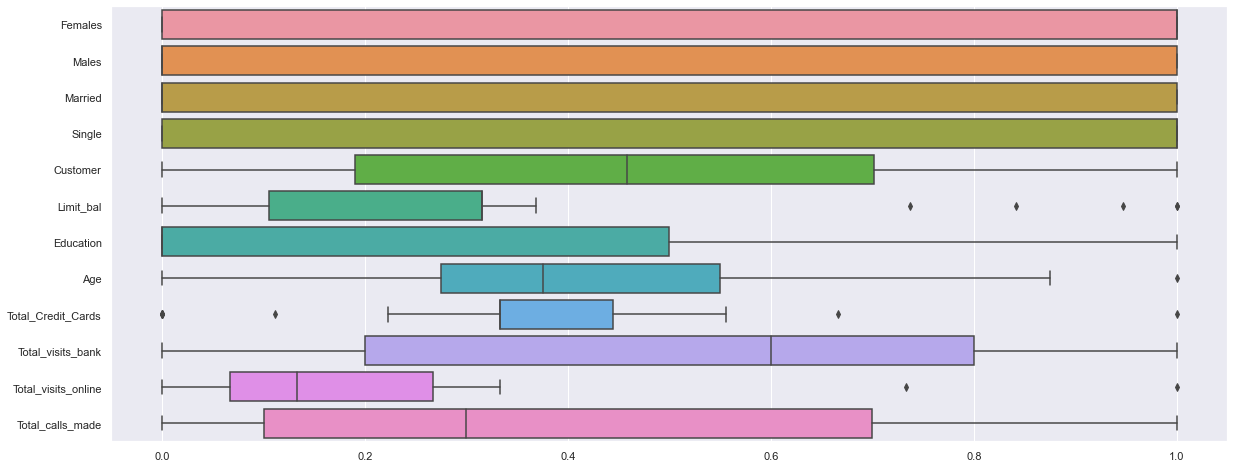

In [30]:
# Graficamos los outilers
fig=plt.figure(figsize=(20,8))
df_plot = pd.DataFrame(minmax_scale(df_out), columns = df.columns)

ax = sns.boxplot(data= df_plot, orient="h")

In [31]:
# Seleccionamos los elementos restantes
df_main = df.loc[df.index.difference(df_out.index)]
df_main

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.0,0.0,1.0,0.0,0.481598,0.209677,0.2,0.222222,0.444444,0.4,0.133333,0.3
1,1.0,0.0,0.0,1.0,0.855833,0.016129,0.2,0.055556,0.111111,0.2,0.066667,0.0
2,1.0,0.0,0.0,1.0,0.306498,0.177419,0.2,0.092593,0.222222,0.0,0.666667,0.9
3,1.0,0.0,1.0,0.0,0.068595,0.129032,0.2,0.240741,0.666667,0.2,0.200000,0.4
4,0.0,1.0,1.0,0.0,0.330003,0.064516,0.2,0.296296,0.444444,0.2,0.066667,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,1.0,0.0,0.0,1.0,0.449807,0.435484,0.2,0.333333,1.000000,0.2,0.666667,0.0
653,1.0,0.0,0.0,1.0,0.558457,0.451613,0.4,0.111111,1.000000,0.2,0.866667,0.2
654,1.0,0.0,0.0,1.0,0.480582,0.290323,0.0,0.129630,0.777778,0.2,0.600000,0.1
655,1.0,0.0,0.0,1.0,0.783377,0.112903,0.0,0.037037,1.000000,0.2,1.000000,0.0


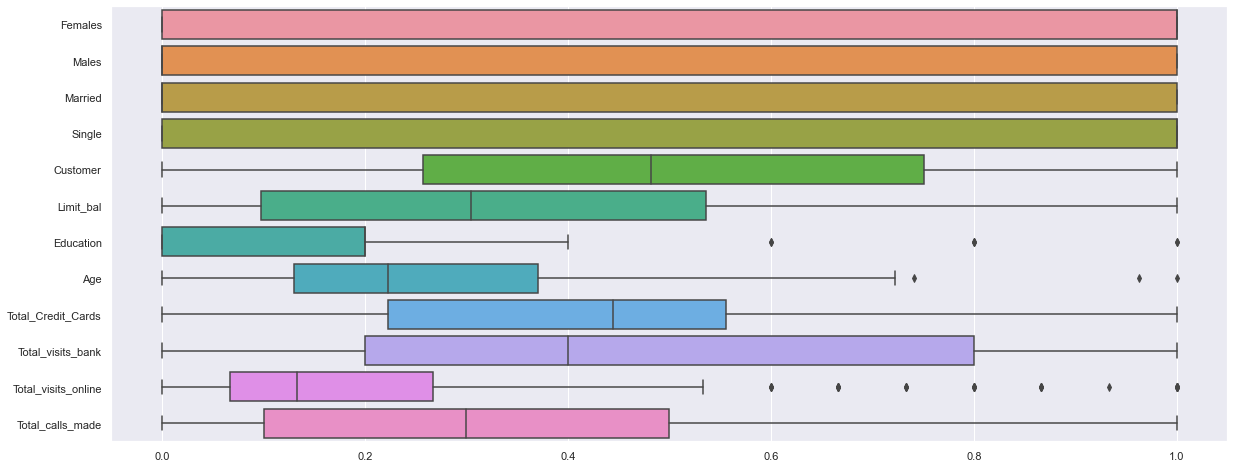

In [32]:
#Se ven los datos sin los outliers
fig=plt.figure(figsize=(20,8))
df_plot = pd.DataFrame(minmax_scale(df_main), columns = df.columns)

ax = sns.boxplot(data= df_plot, orient="h")

# K-Means

Selección de hiperparámetros para K-Means

In [33]:
def plot_distortion(data,
                    k_min=1, 
                    k_max=11,
                    ylabel = 'Distortion',
                    xlabel = 'Number of clusters',
                    title = 'Distortion Plot'):
    '''
    Graficar el codo de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    xlabel : string
        La etiqueta del eje x
    ylabel  string
        La etiqueta del eje y    
    title : string
        El titulo de la gráfica  
    '''
    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 n_init=10,
                 max_iter=300,
                 random_state=seed)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


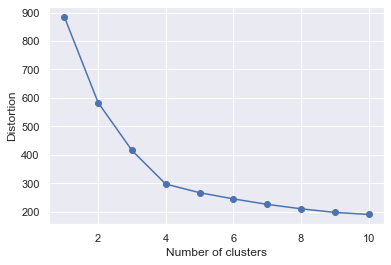

In [34]:
#Se evidencia que el codo son 4 clústers
plot_distortion(df_main)

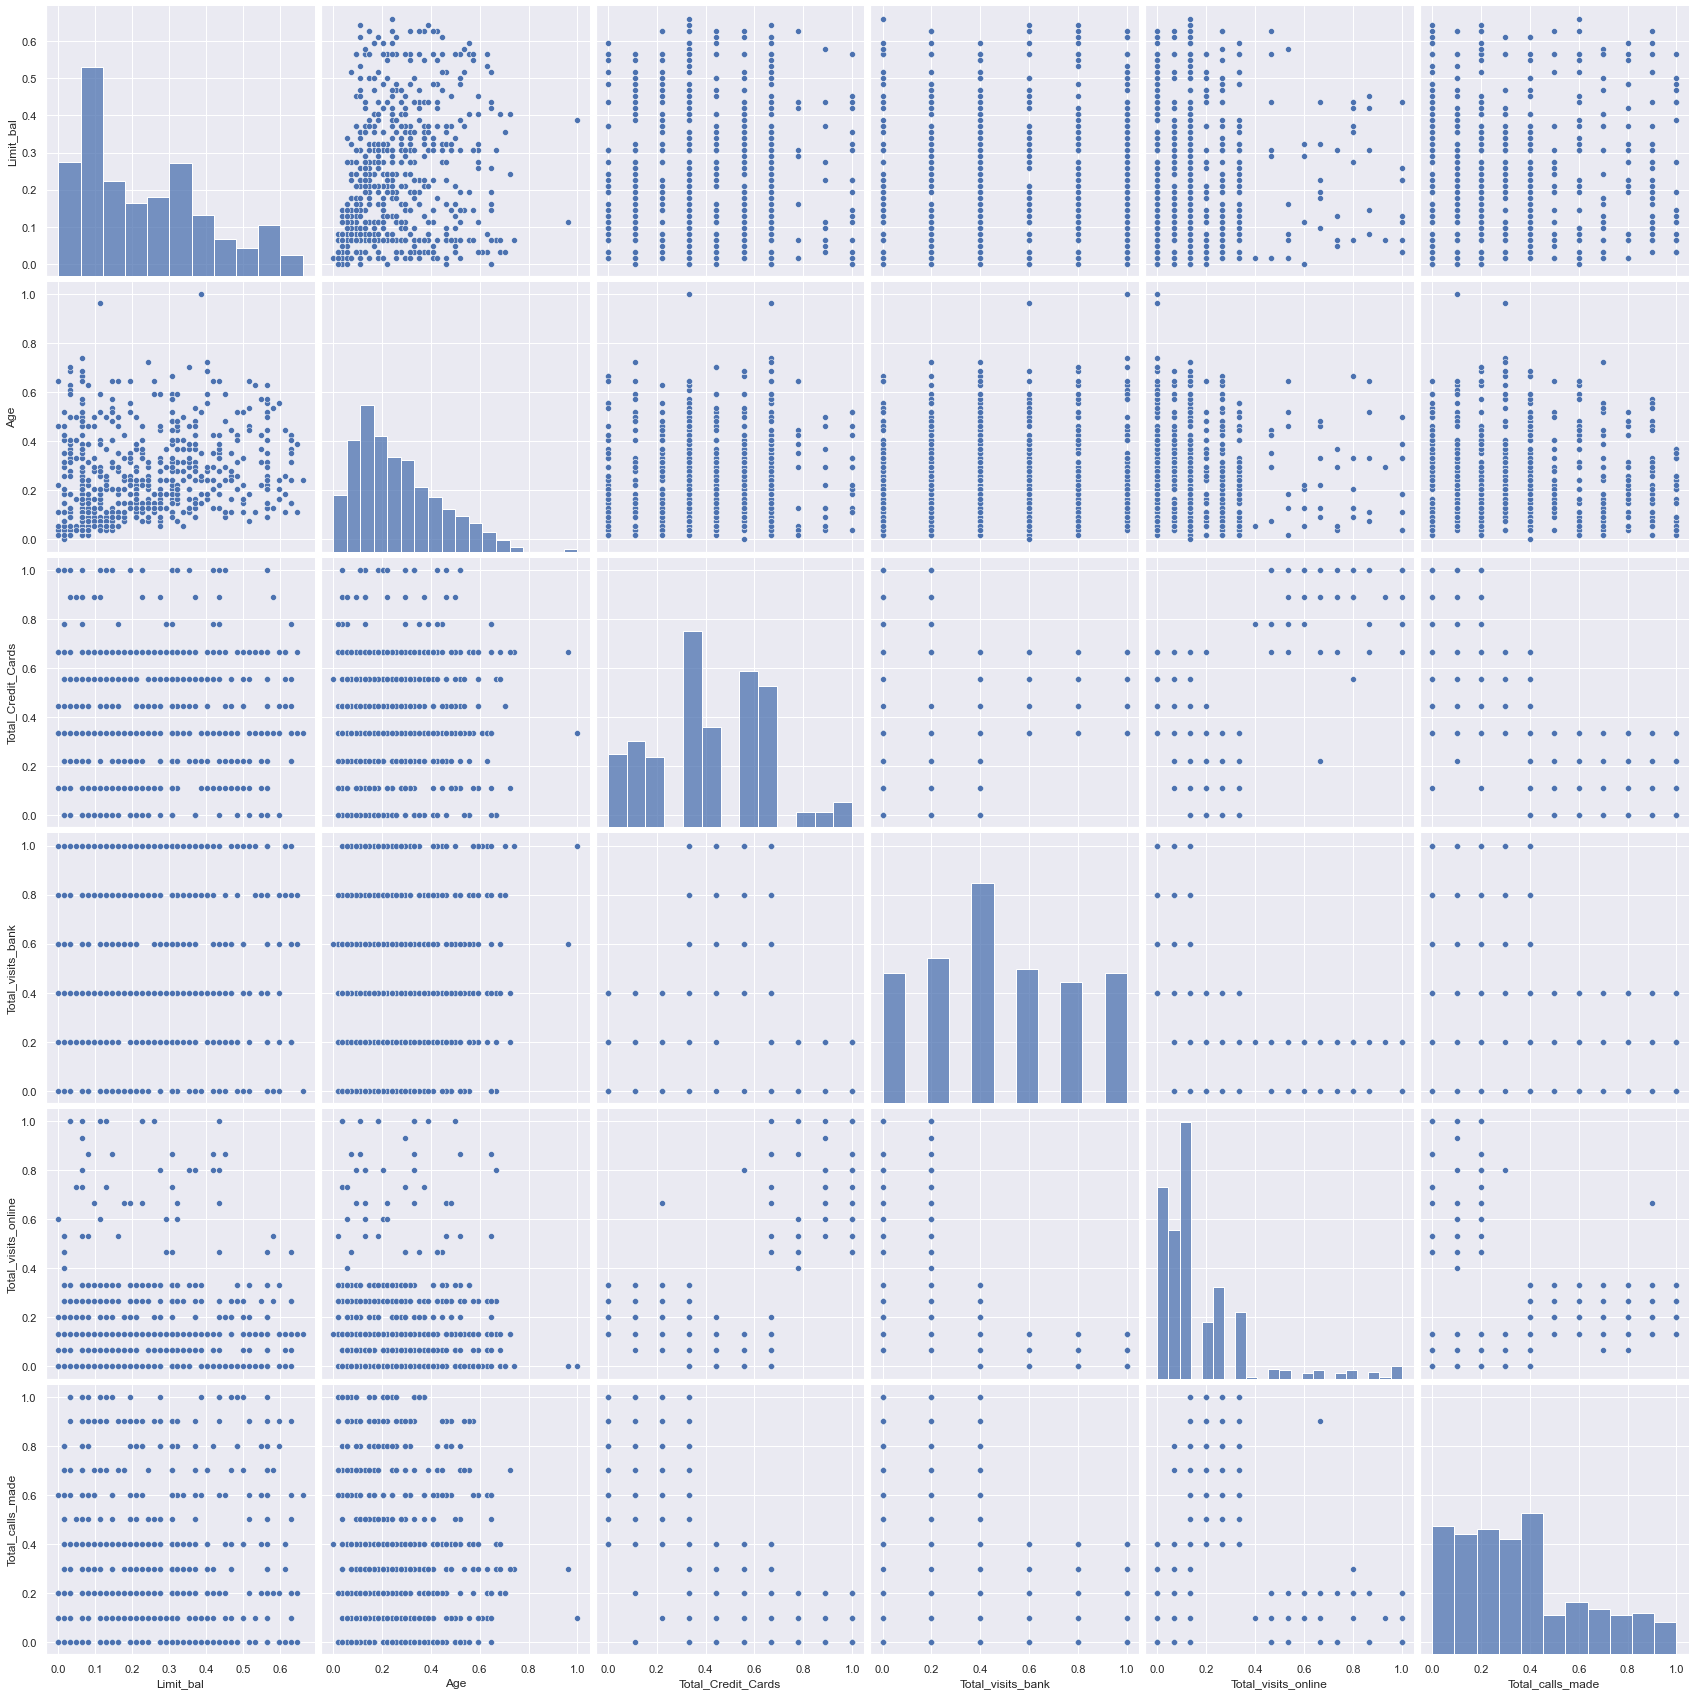

In [35]:
#Basándonos en estas gráficas, la mejor opción para la segmentación son las columnas Age, Limit_bal, Total_Credits_Cards, 
#Total_visits_bank,Total_visits_online y Total_calls_made
#Se apartan esas columnas de las demás
selected_cols = ['Limit_bal','Age','Total_Credit_Cards',
          'Total_visits_bank','Total_visits_online','Total_calls_made']
sns.pairplot(df_main, height=4,vars=selected_cols,kind='scatter')

In [36]:
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    '''
    Graficar la silueta de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica        
    '''
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

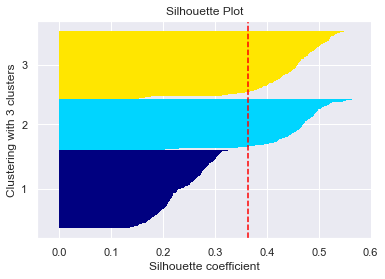

In [37]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(df_main)
plot_silhouette(data = df_main, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

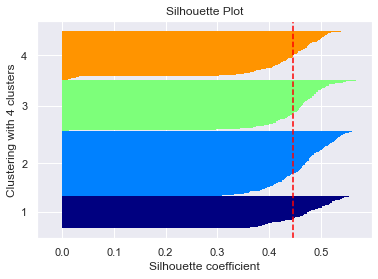

In [38]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(df_main)
plot_silhouette(data = df_main, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

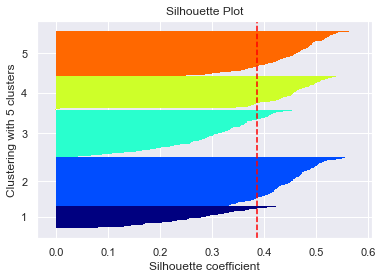

In [39]:
n_clusters = 5
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(df_main)
plot_silhouette(data = df_main, 
                labels = km.labels_, 
                ylabel = f'Clustering with {n_clusters} clusters')

In [40]:
#Se evidencia que el mejor número de clústers es 4 porque no tiene elementos mal asignados (con coeficiente menor a 0) y tiene el promedio de 
#coeficiente de Silhouette más alto.
#Visualizamos los prototipos
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=seed)
km.fit(df_main)
# Crea los prototipos
df_pro = pd.DataFrame(np.transpose(km.cluster_centers_), columns = range(1, n_clusters +1))
df_pro['column'] = df_main.columns
df_pro

,1,2,3,4,column
0,5.551115e-16,1.000000e+00,8.881784e-16,9.808917e-01,Females
1,1.000000e+00,2.775558e-16,9.937500e-01,4.996004e-16,Males
2,1.000000e+00,2.775558e-16,2.775558e-16,9.235669e-01,Married
3,-2.220446e-16,1.000000e+00,9.750000e-01,-4.440892e-16,Single
4,4.815705e-01,5.157148e-01,4.605205e-01,5.192905e-01,Customer
5,2.474700e-01,2.292683e-01,2.014113e-01,2.504623e-01,Limit_bal
6,1.647059e-01,1.512195e-01,1.750000e-01,1.477707e-01,Education
7,2.797749e-01,2.542909e-01,2.605324e-01,2.402689e-01,Age
8,4.084967e-01,4.460705e-01,3.812500e-01,4.225053e-01,Total_Credit_Cards
9,4.941176e-01,4.936585e-01,4.587500e-01,4.828025e-01,Total_visits_bank


<AxesSubplot:xlabel='value', ylabel='column'>

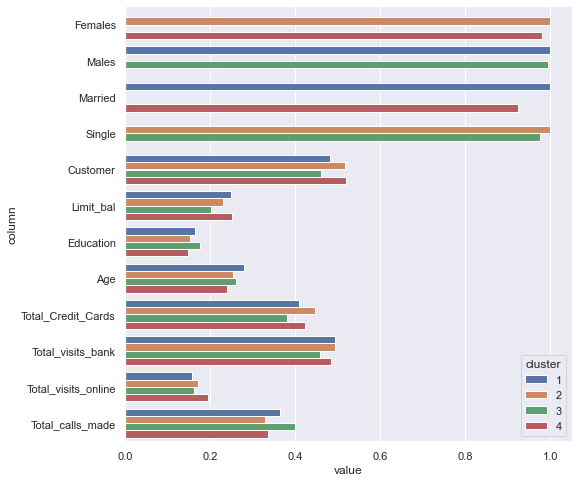

In [41]:
#Queremos saber cuáles columnas definen mejor los clústers. Por la gráfica se puede ver que Age, Limit_bal, Total_Credit_Cards, Total_visits_bank,
# y Total_calls_made son importantes a la hora de crear los cuatro CLÚSTERS.
resp = []
for i in range(1, n_clusters +1):
    df1 = df_pro[['column',i]].rename(columns = {i:'value'})
    df1['cluster'] = i
    resp.append(df1)

df_plot = pd.concat(resp, ignore_index = True)


fig = plt.figure(figsize=(8,8))
sns.barplot(data = df_plot, y = 'column', x = 'value', hue = 'cluster', orient = 'h')

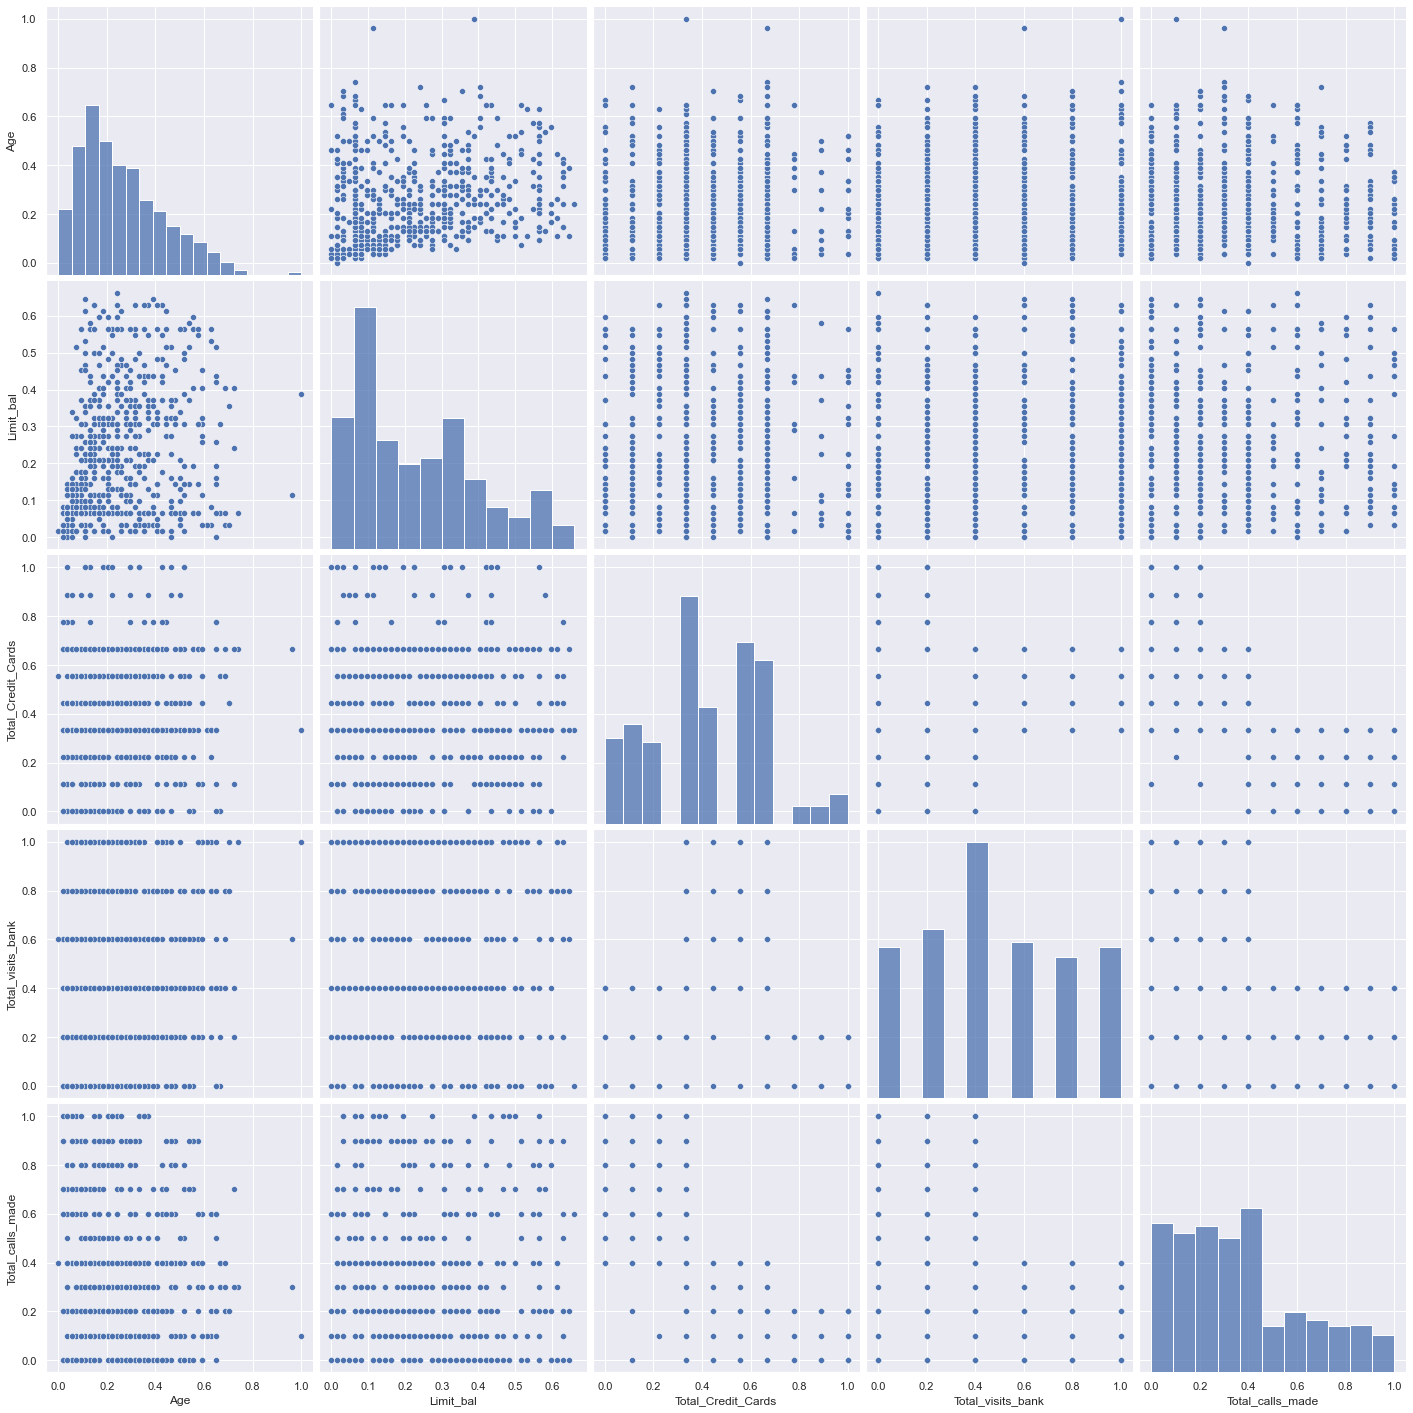

In [42]:
#Ahora, se quiere ver el comportamiento de las columnas que mejor definen los clústers.
selected_cols = ['Age', 'Limit_bal', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_calls_made']
sns.pairplot(df_main, height=4,vars=selected_cols,kind='scatter')

K-Means 

In [43]:
#Las columnas que más prometen para generar clústers son Age y Limit_bal. Entonces hacemos el K-Means con esas dos
# Construimos un nuevo modelo
selected_cols2 = ['Age', 'Limit_bal']
kmeans2 = KMeans(n_clusters=4, random_state=seed) 
kmeans2 = kmeans2.fit(df_main[selected_cols2])

<AxesSubplot:>

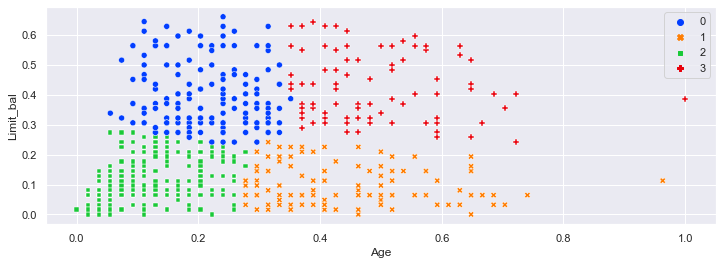

In [44]:
#Visualizamos el resultado
#fig = plt.figure(figsize=(6,6))
fig, axes = plt.subplots(1, 1, figsize = (12,4))

sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = kmeans2.labels_, style = kmeans2.labels_, palette = 'bright')

sns.scatterplot(x = kmeans2.cluster_centers_[:,0], 
                y = kmeans2.cluster_centers_[:,1], 
                color = 'red',
                s = 100,
                marker = 'P',                
                ax = ax)

In [45]:
# Crea los prototipos
#Nos convencemos que la diferencia en los clústers la da la columna Age.la edad siempre tiene una influencia considerable en cada clúster, Siempre 
#tiene mayor diferencia.
df_prototype = pd.DataFrame(kmeans2.cluster_centers_, columns = selected_cols2)
df_prototype

,Age,Limit_bal
0,0.208521,0.397259
1,0.431346,0.096643
2,0.120027,0.112239
3,0.491503,0.422391


In [46]:
# Los reconstruimos. Queremos saber los valores no reescalados de los prototipos.
# Incluimos las columnas viejas
for col in df.columns:
    if col not in df_prototype.columns:
        df_prototype[col] = None
        
# Ordena
df_prototype = df_prototype[df.columns]

# Devuelve la transformacion
values = trans.inverse_transform(df_prototype)
df_prototype = pd.DataFrame(values, columns = df_prototype.columns)

# Imprime
df_prototype[selected_cols2]

,Age,Limit_bal
0,32.260116,256300.578035
1,44.292683,69918.699187
2,27.481481,79588.477366
3,47.541176,271882.352941


# Gaussian Mixture Model

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

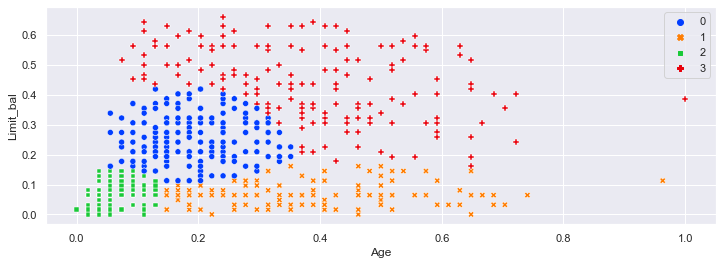

In [47]:
#Gaussian Mixture sin hiperparámetros.
gmm = GaussianMixture(n_components=4).fit(df_main[selected_cols2])
pred = gmm.predict(df_main[selected_cols2])
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = pred, style = pred, palette = 'bright')

Selección de Hiperparámetros para Gaussian Mixture Model

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


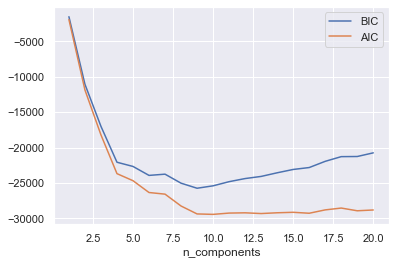

In [48]:
#Clústers para este modelo. Usaremos los criterios Akaike information criterion (AIC) y Bayesian information criterion (BIC).
#El mejor número de clústers es el valor que minimiza los criterios de la gráfica. Se puede ver que el valor está entre 
#9 o 10 clústers. Escoger el número correcto de clústers nos ayuda a que Gaussian Mixture se comporte mejor en la estimación
#de densidad de datos, más no a que el algoritmo de clustering sea más efectivo. Es decir que Gaussian Mixture, con la estimación
#de densidad adecuada, también puede comportarse como un modelo probabilístico que describe la distribución de los datos.
#GMM es conveniente no solo para clustering, sino también como modelaje de aribitrarias distribuciones multidimensaionales de 
#datos (en su faceta de estimador de densidad). Este hiperparámetro al negocio le puede llegar a ser útil para conocer cómo se
#distribuyen las características de sus clientes y poder enfocar el marketing basados en esa información.  
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df_main)
          for n in n_components]

plt.plot(n_components, [m.bic(df_main) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_main) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

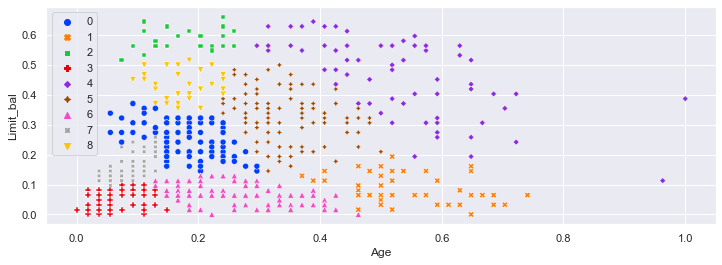

In [49]:
#Imprimimos con 9 clústers
gmm2 = GaussianMixture(n_components=9).fit(df_main[selected_cols2])
pred = gmm2.predict(df_main[selected_cols2])
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = pred, style = pred, palette = 'bright')

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

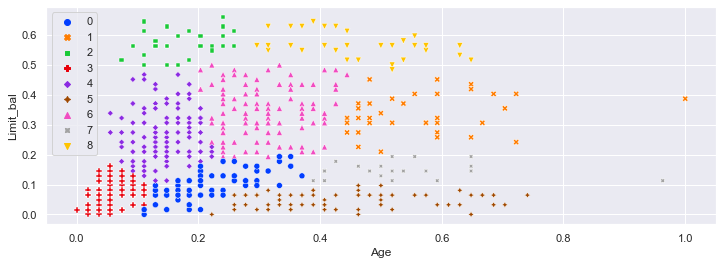

In [50]:
#Para la covarianza:
#covariance_type="diag" - El tamaño del clúster en cada dimensión se establece de forma independiente.Cada componente tiene su 
#propia diagonal en la matriz de covarianzas.
#covariance_type="spherical" - Es más rápido y, asimismo, más simple. Los clústers se distribuirán con las mismas dimensiones.
#Da un resultado similar a K-Means, pero no es del todo equivalente. Cada clúster tiene su propia varianza
#covariance_type="full" - Permite modelar cada clúster con una orientación arbitraria. Es el más costoso computacionalmente y
#el más complicado. Todos los componentes tienen su propia matriz de covarianza
#Por negocio, dado que sólo tenemos las columnas Age y Limit_bal para orientar el marketing, podemos sacar el modelo Gaussian 
#Mixture con la covarianza en full. Además, queremos informarle a negocio los clústers más precisos posibles.
gmm3 = GaussianMixture(n_components=9,covariance_type='full').fit(df_main[selected_cols2])
pred = gmm3.predict(df_main[selected_cols2])
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = pred, style = pred, palette = 'bright')

# DBSCAN

In [51]:
#Se retoma el conjunto de datos 
df_main.describe()

,Females,Males,Married,Single,Customer,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,0.575321,0.418269,0.395833,0.578526,0.496881,0.230433,0.158654,0.256529,0.417379,0.482051,0.172329,0.354167
std,0.494691,0.493671,0.489421,0.494191,0.290532,0.172588,0.155856,0.172658,0.240507,0.323799,0.195171,0.283096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.257513,0.064516,0.000000,0.129630,0.222222,0.200000,0.066667,0.100000
50%,1.000000,0.000000,0.000000,1.000000,0.481598,0.201613,0.200000,0.222222,0.444444,0.400000,0.133333,0.300000
75%,1.000000,1.000000,1.000000,1.000000,0.750864,0.354839,0.200000,0.370370,0.555556,0.800000,0.266667,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.661290,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
#Se busca el valor optimo del parametro epsilon para el modelo, empezando con los un valor de 2 para la cantidad de vecinos cercanos.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_main)
distances, indexes = nbrs.kneighbors(df_main)


In [53]:
#Como se puede ver, esto nos entrega una lista con la distancia al punto más cercano para cada punto
print(distances)
print(indexes)

[[0.         0.24916788]
 [0.         0.42554525]
 [0.         0.40575309]
 ...
 [0.         0.40907367]
 [0.         0.36996261]
 [0.         0.31346854]]
[[  0 452]
 [  1 229]
 [  2  46]
 ...
 [621 619]
 [622 587]
 [623 615]]


Text(0, 0.5, 'distance')

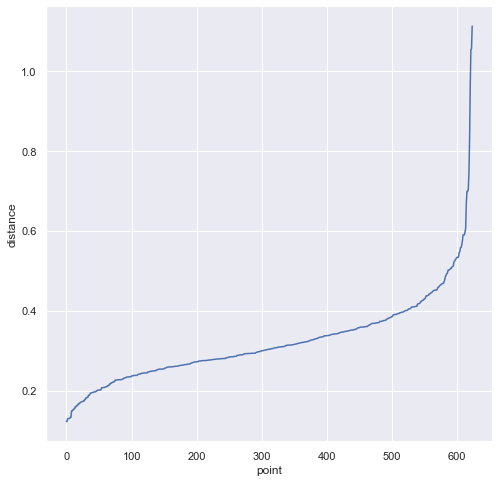

In [54]:
#Si ahora se grafica esto, es posible visibilizar un codo que corresponde al valor optimo de epsilon.
#Notese que la busqueda de este codo es distinta a las anteriores, debido a que aqui se esta buscando el valor para epsilon,
# no para la cantidad de clusters a buscar.
distances=np.sort(distances, axis =0)
distances=distances[:,1]

fig = plt.figure(figsize=(8,8))
plt.plot(distances)
plt.xlabel("point")
plt.ylabel("distance")

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

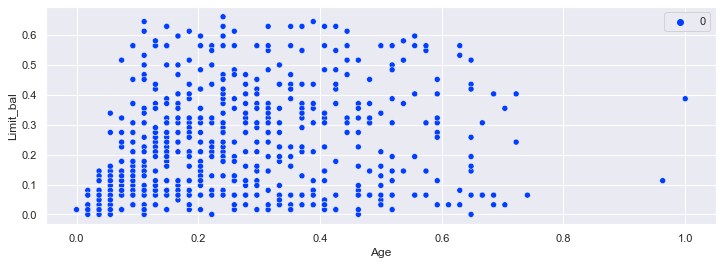

In [55]:
#A partir de esto, se ejecuta el modelo con un valor de epsilon de 0.4 y un valor para min_samples de 2.
db = DBSCAN(eps=0.4,min_samples=2).fit(df_main[selected_cols2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labelsdb = db.labels_
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = labelsdb, style = labelsdb, palette = 'bright')

Text(0, 0.5, 'distance')

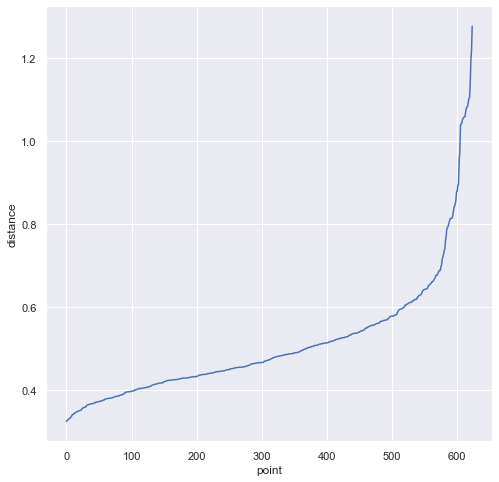

In [56]:
#Como se puede ver, esto no fue de gran utilidad ya que solo nos retorna un modelo. 
#Por esto, procederemos a cambiar el valor de min_samples a 10
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(df_main)
distances, indexes = nbrs.kneighbors(df_main)
distances=np.sort(distances, axis =0)
distances=distances[:,9]

fig = plt.figure(figsize=(8,8))
plt.plot(distances)
plt.xlabel("point")
plt.ylabel("distance")

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

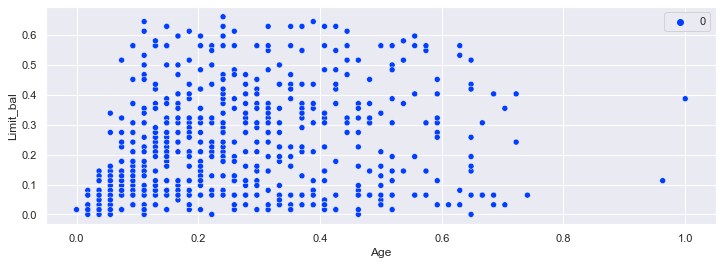

In [57]:
#Se ejecuta de nuevo el modelo con los nuevos valores de parametros.
db = DBSCAN(eps=0.6,min_samples=10).fit(df_main[selected_cols2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labelsdb = db.labels_
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = labelsdb, style = labelsdb, palette = 'bright')

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

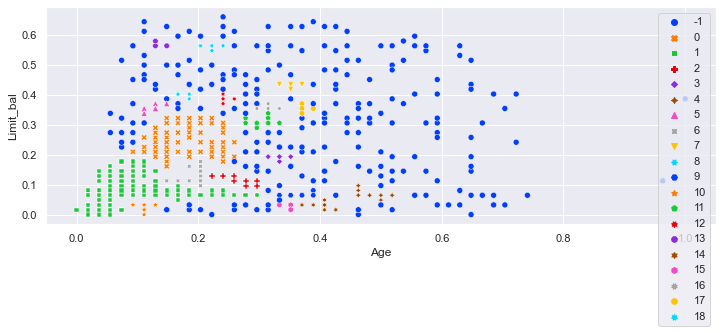

In [58]:
#Una vez mas se obtiene un unico cluster, por lo que se procede a modificar los parametros de forma arbitraria.
#Se empieza con un valor pequeño para epsilon
db = DBSCAN(eps=0.02,min_samples=5).fit(df_main[selected_cols2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labelsdb = db.labels_
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = labelsdb, style = labelsdb, palette = 'bright')

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

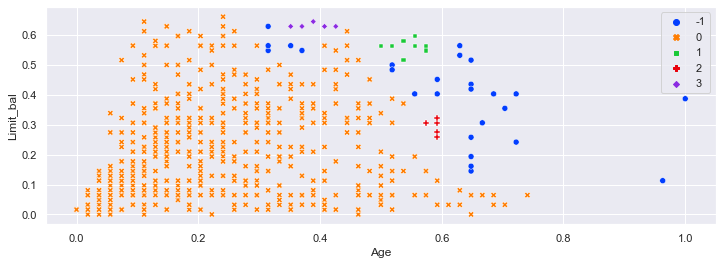

In [59]:
#Como se puede evidenciar, con este valor se obtienen demasiados datos sin clasificar, por lo que se prueba ahora un valor mayor.
db = DBSCAN(eps=0.05,min_samples=5).fit(df_main[selected_cols2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labelsdb = db.labels_
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = labelsdb, style = labelsdb, palette = 'bright')

<AxesSubplot:xlabel='Age', ylabel='Limit_bal'>

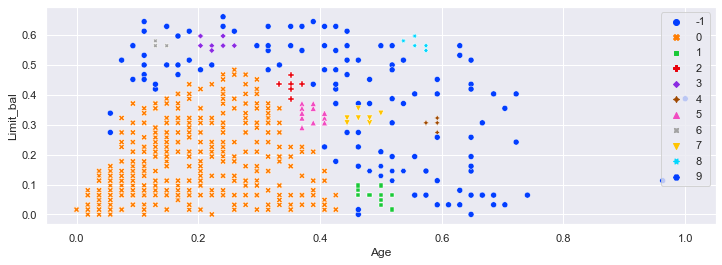

In [60]:
#Con epsilon en 0.5 se obtiene un cluster principal y otros pequeños. 
#Por esta razon se busca un valor ahora entre los dos valores probados
db = DBSCAN(eps=0.035,min_samples=5).fit(df_main[selected_cols2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labelsdb = db.labels_
fig, axes = plt.subplots(1, 1, figsize = (12,4))
sns.scatterplot(data = df_main, x = selected_cols2[0],y = selected_cols2[1], 
                 hue = labelsdb, style = labelsdb, palette = 'bright')

In [61]:
#Una vez mas, se obtiene un conjunto principal. A partir de esto podemos concluir que, debido a la forma en que trabaja DBSCAN, puede
#que este no sea un metodo optimo para clustering.